# Primer intento con MObileNetV2

Llamar la carpeta y clasificar cada imagen para entrenamiento y validacion

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix



# Parámetros importantes
img_size = (224, 224)
batch_size = 32

# Ruta a la carpeta principal de imágenes
ruta_imagenes = "Multi-Class Driver Behavior Image Dataset"

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    ruta_imagenes,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    ruta_imagenes,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: 'Multi-Class Driver Behavior Image Dataset'

Utilizaremos un algoritmo mas complejo llamado MobileNetV2Efficient

In [15]:
# Cargar MobileNetV2 sin la parte final (sin las capas de clasificación)
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=img_size + (3,)
)
base_model.trainable = False # Congelamos la base para transfer learning

# Añadir nuevas capas para tu problema
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Compilar modelo

In [16]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Comenzar con el entrenamiento de modelo

In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop]
)

#Fine-tuning: descongelar la base y entrenar 10 épocas más
base_model.trainable = True
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 112s 600ms/step - accuracy: 0.2209 - loss: 2.0990 - val_accuracy: 0.2727 - val_loss: 1.7033
Epoch 2/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 106s 582ms/step - accuracy: 0.2968 - loss: 1.8190 - val_accuracy: 0.3588 - val_loss: 1.6009
Epoch 3/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 106s 582ms/step - accuracy: 0.3444 - loss: 1.6476 - val_accuracy: 0.4125 - val_loss: 1.5525
Epoch 4/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 105s 576ms/step - accuracy: 0.4247 - loss: 1.4677 - val_accuracy: 0.4642 - val_loss: 1.4742
Epoch 5/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 105s 578ms/step - accuracy: 0.4558 - loss: 1.3796 - val_accuracy: 0.4883 - val_loss: 1.4459
Epoch 6/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 105s 579ms/step - accuracy: 0.4940 - loss: 1.2803 - val_accuracy: 0.5110 - val_loss: 1.4066
Epoch 7/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 105s 578ms/step - accuracy: 0.5180 - loss: 1.2045 - val_accuracy: 0.5227 - val_loss: 1.3845
Epoch 8/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 105s 577ms/step - accuracy: 0.5512 -

ver resultados

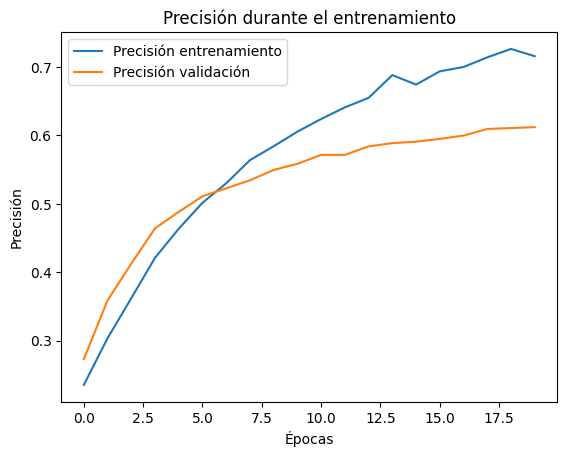

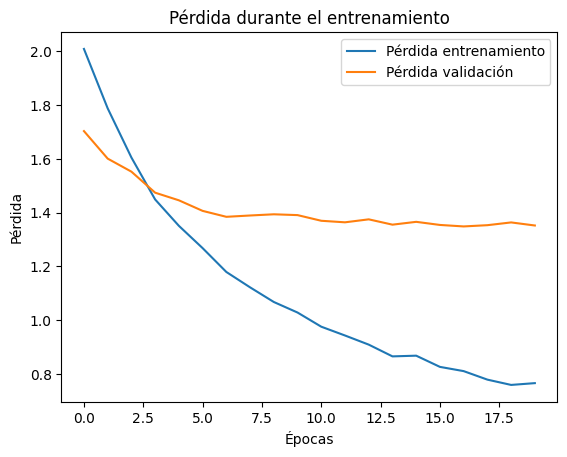

In [18]:
import matplotlib.pyplot as plt

# Precisión
plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Precisión durante el entrenamiento')
plt.show()

# Pérdida
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida durante el entrenamiento')
plt.show()

In [19]:
val_loss, val_acc = model.evaluate(val_gen)
print(f'Precisión en validación: {val_acc:.2f}')
print(f'Pérdida en validación: {val_loss:.2f}')

46/46 ━━━━━━━━━━━━━━━━━━━━ 44s 943ms/step - accuracy: 0.6717 - loss: 1.0666
Precisión en validación: 0.67
Pérdida en validación: 1.11


Matriz de confusion

In [20]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Obtener predicciones
val_gen.reset()
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_gen.classes

# Nombres de las clases
class_labels = list(val_gen.class_indices.keys())

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)
print("Matriz de confusión:")
print(cm)

# Reporte de clasificación
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print("Reporte de clasificación:")
print(report)

46/46 ━━━━━━━━━━━━━━━━━━━━ 45s 950ms/step
Matriz de confusión:
[[42 64 37 41 52]
 [72 90 54 69 50]
 [83 64 44 51 60]
 [60 70 51 69 62]
 [51 75 45 51 45]]
Reporte de clasificación:
                  precision    recall  f1-score   support

other_activities       0.14      0.18      0.15       236
    safe_driving       0.25      0.27      0.26       335
   talking_phone       0.19      0.15      0.17       302
   texting_phone       0.25      0.22      0.23       312
         turning       0.17      0.17      0.17       267

        accuracy                           0.20      1452
       macro avg       0.20      0.20      0.20      1452
    weighted avg       0.20      0.20      0.20      1452



### Dio un resultado de 20 porciento se equivoca mucho entre ellos y el tiempo de entrenamiento es de mas de 1 hora y media siendo ineficiente en la practica y para usarlo vamos a provar otro

# Segundo intento usando EfficientNetB0-B2-B3

llamada de librerias y archivo

In [46]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


# Parámetros
img_size = (224, 224)
batch_size = 32
ruta_imagenes = "Multi-Class Driver Behavior Image Dataset"

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    ruta_imagenes,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)
val_gen = val_datagen.flow_from_directory(
    ruta_imagenes,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False  # Importante para análisis de resultados
)

Found 5824 images belonging to 5 classes.
Found 1452 images belonging to 5 classes.


In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=img_size + (1,)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

ejemplo de las imagenes que vera el modelo

Found 5824 images belonging to 5 classes.
Found 1452 images belonging to 5 classes.


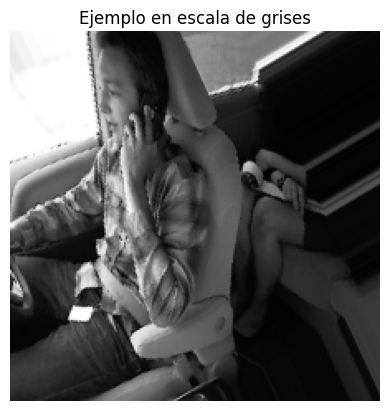

In [48]:
train_gen = train_datagen.flow_from_directory(
    ruta_imagenes,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',  # ¡IMPORTANTE!
    class_mode='categorical',
    subset='training',
    shuffle=True
)
val_gen = val_datagen.flow_from_directory(
    ruta_imagenes,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',  # ¡IMPORTANTE!
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


x_batch, y_batch = next(train_gen)
plt.imshow(x_batch[0].squeeze(), cmap='gray')
plt.title('Ejemplo en escala de grises')
plt.axis('off')
plt.show()

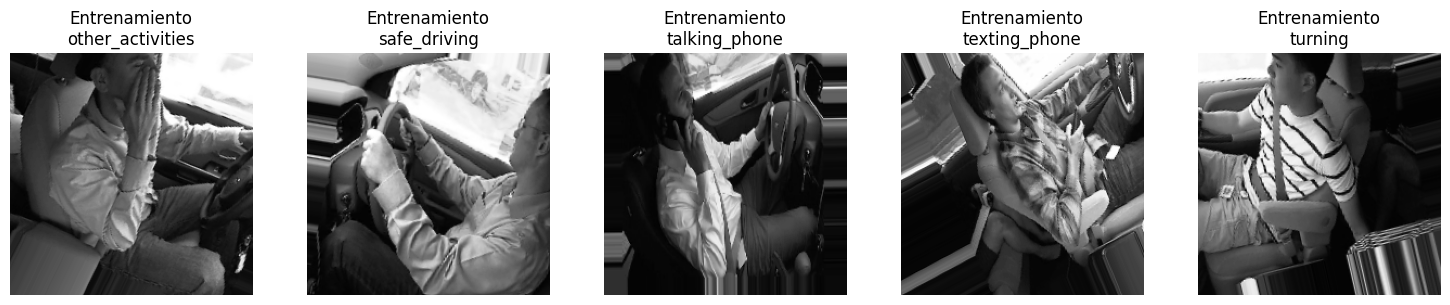

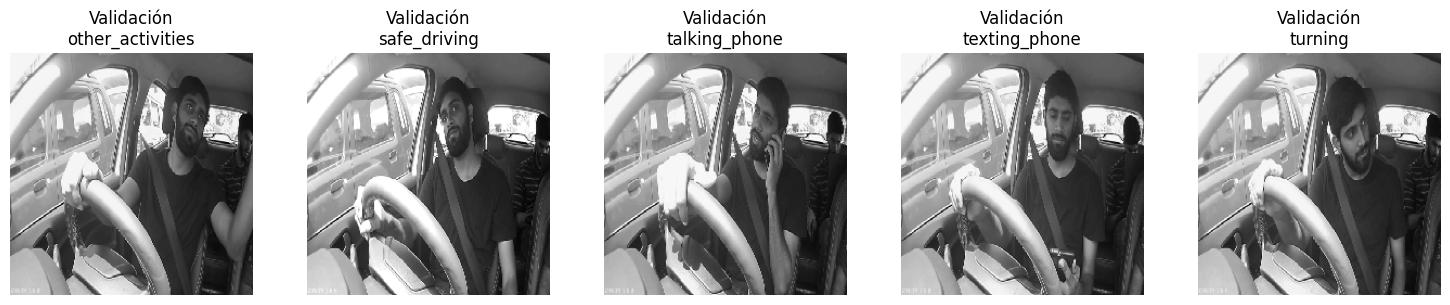

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener los nombres de las clases
class_labels = list(train_gen.class_indices.keys())
num_classes = len(class_labels)

# Función para mostrar una imagen random de cada clase desde un generador
def mostrar_imagenes_por_clase(generator, tipo="Entrenamiento"):
    plt.figure(figsize=(15, 3))
    # Para cada clase
    for i, class_name in enumerate(class_labels):
        encontrado = False
        while not encontrado:
            x_batch, y_batch = next(generator)
            for j in range(x_batch.shape[0]):
                label = np.argmax(y_batch[j])
                if label == i:
                    plt.subplot(1, num_classes, i+1)
                    plt.imshow(x_batch[j].squeeze(), cmap='gray')  # Escala de grises
                    plt.title(f"{tipo}\n{class_name}")
                    plt.axis('off')
                    encontrado = True
                    break
    plt.tight_layout()
    plt.show()

# Mostrar imágenes de entrenamiento
mostrar_imagenes_por_clase(train_gen, tipo="Entrenamiento")

# Mostrar imágenes de validación
mostrar_imagenes_por_clase(val_gen, tipo="Validación")

Se decidio usar escalas de grises ya que el color no es necesario para determinar que tipo de categoria queda la imagen.

Modelo EfficientNetB3 y su entrenamiento

In [50]:
base_model = EfficientNetB3(
    weights='imagenet',
    include_top=False,
    input_shape=img_size + (3,)
)
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=[early_stop]
)

# Fine-tuning
base_model.trainable = True
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=12,
    callbacks=[early_stop]
)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 309s 2s/step - accuracy: 0.1927 - loss: 1.6757 - val_accuracy: 0.1839 - val_loss: 1.6151
Epoch 2/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.1942 - loss: 1.6421 - val_accuracy: 0.2307 - val_loss: 1.6045
Epoch 3/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - accuracy: 0.2077 - loss: 1.6307 - val_accuracy: 0.2307 - val_loss: 1.6029
Epoch 4/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.2204 - loss: 1.6347 - val_accuracy: 0.2307 - val_loss: 1.6026
Epoch 5/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.2042 - loss: 1.6366 - val_accuracy: 0.2307 - val_loss: 1.6025
Epoch 6/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.2152 - loss: 1.6291 - val_accuracy: 0.2307 - val_loss: 1.6025
Epoch 7/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.1999 - loss: 1.6402 - val_accuracy: 0.2307 - val_loss: 1.6025
Epoch 8/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - accuracy: 0.2156 - loss: 1.6279 - val_accu

KeyboardInterrupt: 

ver resultados

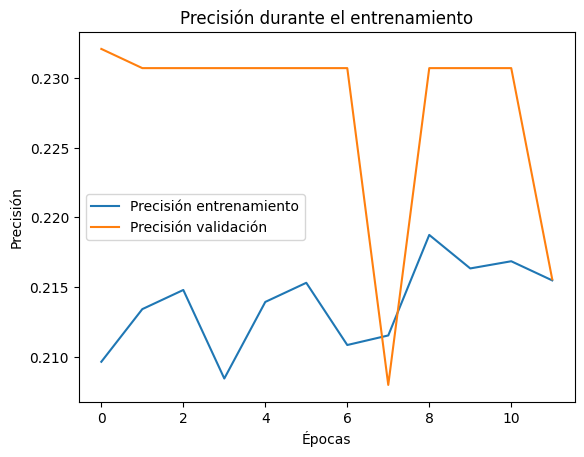

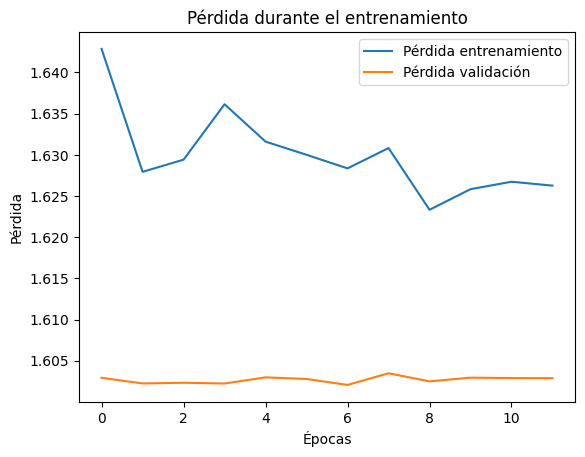

In [34]:
import matplotlib.pyplot as plt

# Precisión
plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Precisión durante el entrenamiento')
plt.show()

# Pérdida
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida durante el entrenamiento')
plt.show()

In [35]:
val_loss, val_acc = model.evaluate(val_gen)
print(f'Precisión en validación: {val_acc:.2f}')
print(f'Pérdida en validación: {val_loss:.2f}')

46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.2532 - loss: 1.5802
Precisión en validación: 0.26
Pérdida en validación: 1.57


Matriz visual

46/46 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step


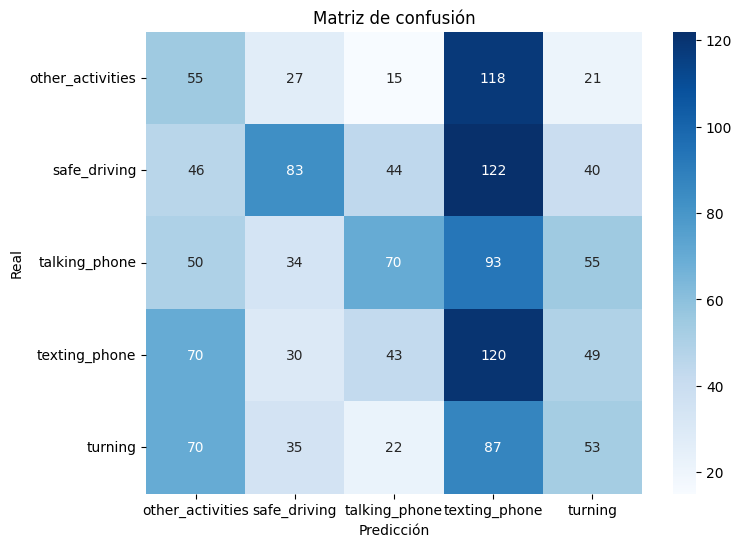

In [36]:
# Predicciones
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión')
plt.show()

visualizar ejemplos con prediccion y probabilidad

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


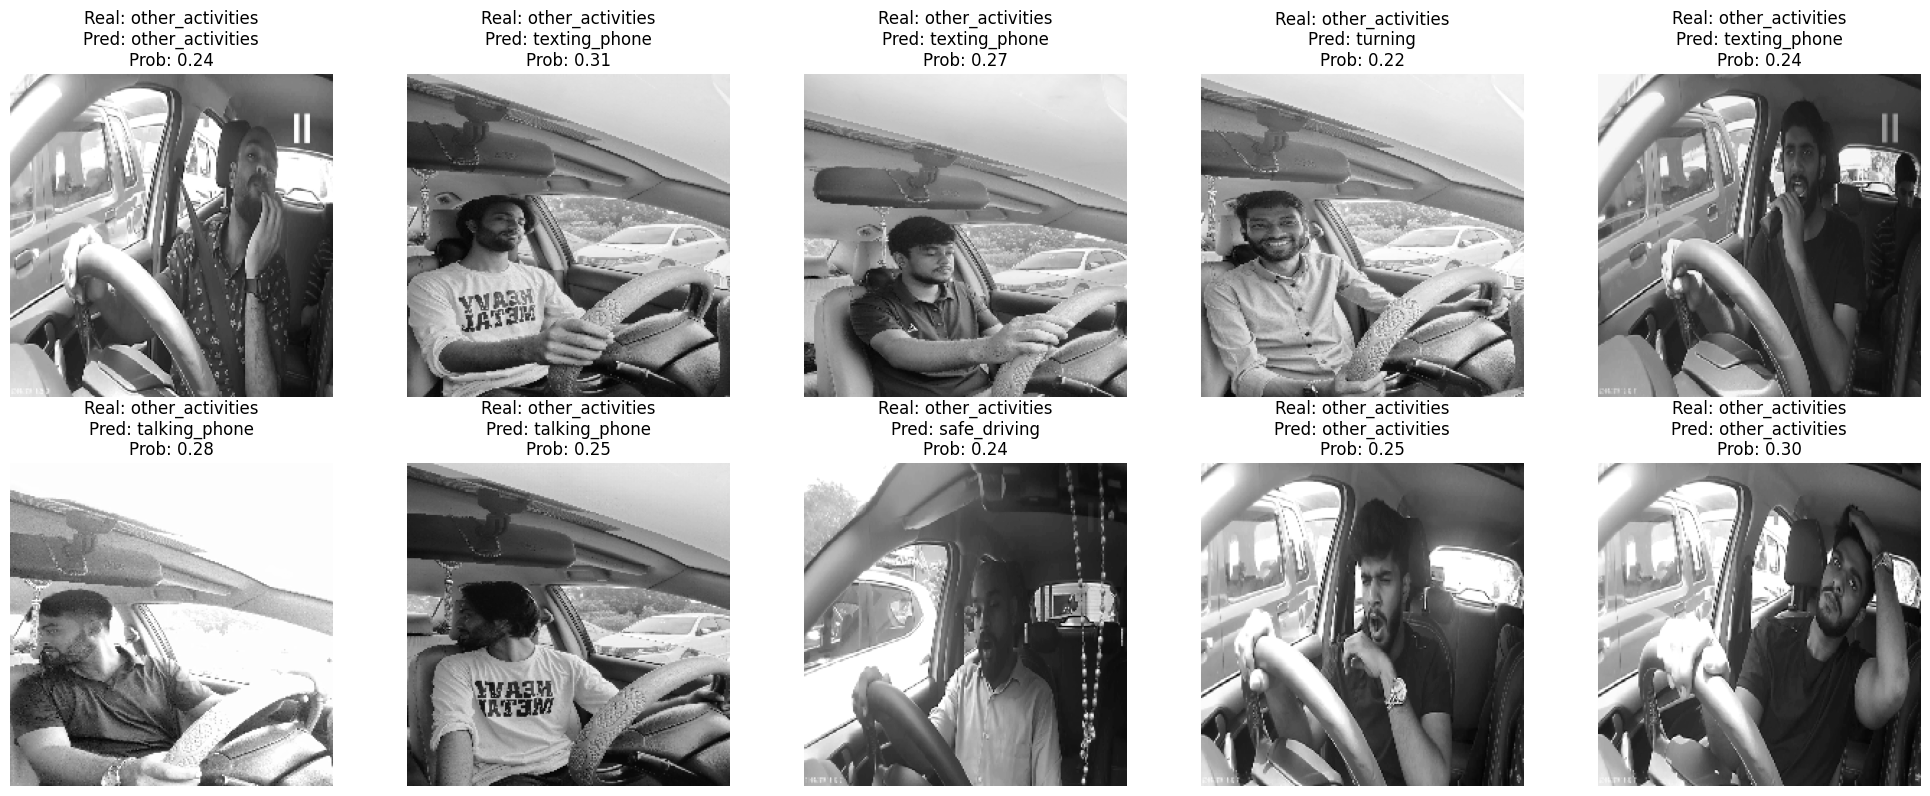

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Obtén un batch grande de validación (o recorre varios batches)
x_val, y_val = next(val_gen)
for _ in range(5):  # Para asegurar que tienes suficientes imágenes
    x_temp, y_temp = next(val_gen)
    x_val = np.concatenate([x_val, x_temp], axis=0)
    y_val = np.concatenate([y_val, y_temp], axis=0)

# Selecciona 10 índices aleatorios
num_ejemplos = 10
indices = random.sample(range(x_val.shape[0]), num_ejemplos)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, idx in enumerate(indices):
    img = x_val[idx:idx+1]  # Mantén la dimensión batch
    label = y_val[idx]
    pred = model.predict(img)
    pred_class = np.argmax(pred, axis=1)[0]
    true_class = np.argmax(label)
    prob = np.max(pred)
    ax = axes[i//5, i%5]
    # Si es escala de grises
    if img.shape[-1] == 1:
        ax.imshow(img[0].squeeze(), cmap='gray')
    else:
        ax.imshow(img[0])
    ax.axis('off')
    ax.set_title(f"Real: {class_labels[true_class]}\nPred: {class_labels[pred_class]}\nProb: {prob:.2f}")

plt.tight_layout()
plt.show()

In [38]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Obtener predicciones
val_gen.reset()
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_gen.classes

# Nombres de las clases
class_labels = list(val_gen.class_indices.keys())

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)
print("Matriz de confusión:")
print(cm)

# Reporte de clasificación
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print("Reporte de clasificación:")
print(report)

46/46 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step
Matriz de confusión:
[[ 55  27  15 118  21]
 [ 46  83  44 122  40]
 [ 50  34  70  93  55]
 [ 70  30  43 120  49]
 [ 70  35  22  87  53]]
Reporte de clasificación:
                  precision    recall  f1-score   support

other_activities       0.19      0.23      0.21       236
    safe_driving       0.40      0.25      0.31       335
   talking_phone       0.36      0.23      0.28       302
   texting_phone       0.22      0.38      0.28       312
         turning       0.24      0.20      0.22       267

        accuracy                           0.26      1452
       macro avg       0.28      0.26      0.26      1452
    weighted avg       0.29      0.26      0.26      1452



## Presenta mejores valores que el anterior modelo pero sigue siendo muy bajo entonces lo mejor para este caso sera usar un CNN desde cero ya que la data base es muy grande para evitar el problema de sobre ajuste

# TERCER INTENTO ahora con un CNN

In [70]:
# Llamada de librerías
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import os
from sklearn.utils.class_weight import compute_class_weight

In [71]:
ruta_imagenes = "Multi-Class Driver Behavior Image Dataset"
print("Cantidad de imágenes por clase:")
for clase in os.listdir(ruta_imagenes):
    clase_path = os.path.join(ruta_imagenes, clase)
    if os.path.isdir(clase_path):
        num_imgs = len([f for f in os.listdir(clase_path) if os.path.isfile(os.path.join(clase_path, f))])
        print(f"Clase '{clase}': {num_imgs} imágenes")

# Generador para todas las imágenes
gen = train_datagen.flow_from_directory(
    ruta_imagenes,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True
)


Cantidad de imágenes por clase:
Clase 'other_activities': 1184 imágenes
Clase 'safe_driving': 1679 imágenes
Clase 'talking_phone': 1513 imágenes
Clase 'texting_phone': 1561 imágenes
Clase 'turning': 1339 imágenes
Found 7276 images belonging to 5 classes.


In [72]:
# Parámetros
img_size = (224, 224)  # Puedes probar (224, 224) si tu hardware lo permite
batch_size = 32
ruta_imagenes = "Multi-Class Driver Behavior Image Dataset"

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    ruta_imagenes,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',  # Usa 'grayscale' si prefieres blanco y negro
    class_mode='categorical',
    subset='training',
    shuffle=True
)
val_gen = val_datagen.flow_from_directory(
    ruta_imagenes,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',  # Usa 'grayscale' si prefieres blanco y negro
    class_mode='categorical',
    subset='validation',
    shuffle=False
)
# Obtener los nombres de las clases en el mismo orden que el generador
class_labels = list(train_gen.class_indices.keys())

# Contar cuántas imágenes hay por clase
labels = []
for clase in class_labels:
    clase_path = os.path.join(ruta_imagenes, clase)
    if os.path.isdir(clase_path):
        num_imgs = len([f for f in os.listdir(clase_path) if os.path.isfile(os.path.join(clase_path, f))])
        labels += [clase] * num_imgs

# Convertir los nombres de clase a índices
y_int = [class_labels.index(lbl) for lbl in labels]

# Calcular los pesos balanceados
class_weights = compute_class_weight('balanced', classes=np.unique(y_int), y=y_int)
class_weights_dict = dict(enumerate(class_weights))
print("Pesos para oversampling:", class_weights_dict)

Found 5824 images belonging to 5 classes.
Found 1452 images belonging to 5 classes.
Pesos para oversampling: {0: 1.229054054054054, 1: 0.8667063728409767, 2: 0.9617977528089887, 3: 0.932222934016656, 4: 1.0867811799850635}


Visualización de ejemplos de cada clase

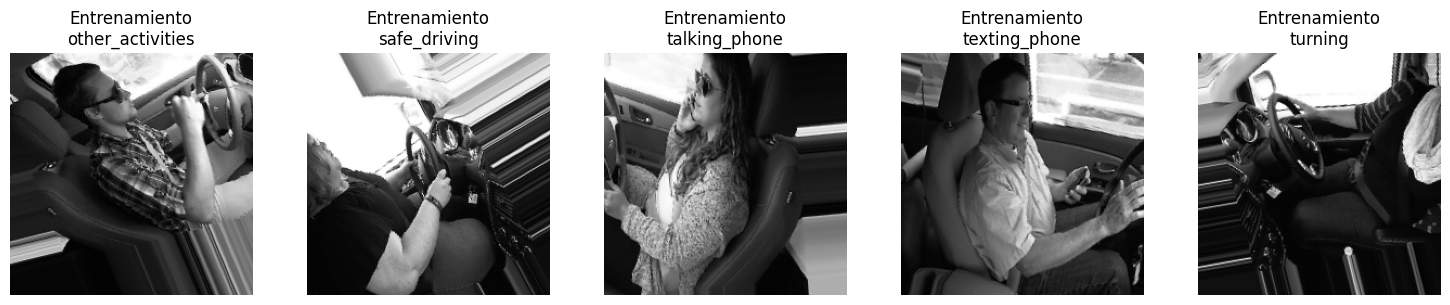

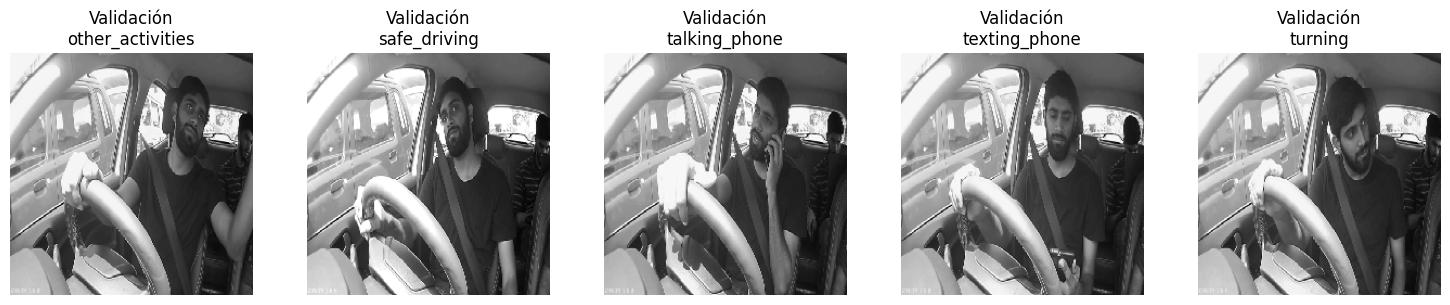

In [73]:
# Visualización de ejemplos de cada clase
class_labels = list(train_gen.class_indices.keys())
num_classes = len(class_labels)

def mostrar_imagenes_por_clase(generator, tipo="Entrenamiento"):
    plt.figure(figsize=(15, 3))
    for i, class_name in enumerate(class_labels):
        encontrado = False
        while not encontrado:
            x_batch, y_batch = next(generator)
            for j in range(x_batch.shape[0]):
                label = np.argmax(y_batch[j])
                if label == i:
                    plt.subplot(1, num_classes, i+1)
                    if x_batch[j].shape[-1] == 1:
                        plt.imshow(x_batch[j].squeeze(), cmap='gray')
                    else:
                        plt.imshow(x_batch[j])
                    plt.title(f"{tipo}\n{class_name}")
                    plt.axis('off')
                    encontrado = True
                    break
    plt.tight_layout()
    plt.show()

mostrar_imagenes_por_clase(train_gen, tipo="Entrenamiento")
mostrar_imagenes_por_clase(val_gen, tipo="Validación")


Modelo desde cero CNN

In [80]:
# Definición de la CNN desde cero
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=img_size + (1,)),  # <--- Cambia aquí
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop],
    class_weight=class_weights_dict  # <--- ¡Aquí!
)

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.2155 - loss: 2.3688 - val_accuracy: 0.2307 - val_loss: 3.9999
Epoch 2/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - accuracy: 0.2239 - loss: 1.6440 - val_accuracy: 0.2204 - val_loss: 2.4991
Epoch 3/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 335s 2s/step - accuracy: 0.2242 - loss: 1.6148 - val_accuracy: 0.2707 - val_loss: 1.6736
Epoch 4/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.2285 - loss: 1.6090 - val_accuracy: 0.2748 - val_loss: 1.5964
Epoch 5/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.2311 - loss: 1.6016 - val_accuracy: 0.2893 - val_loss: 1.5809
Epoch 6/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 370s 2s/step - accuracy: 0.2516 - loss: 1.5931 - val_accuracy: 0.2961 - val_loss: 1.5785
Epoch 7/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 332s 2s/step - accuracy: 0.2517 - loss: 1.5921 - val_accuracy: 0.2617 - val_loss: 1.5949
Epoch 8/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.2537 - loss: 1.5831 - val_accu

Visualización de precisión y pérdida

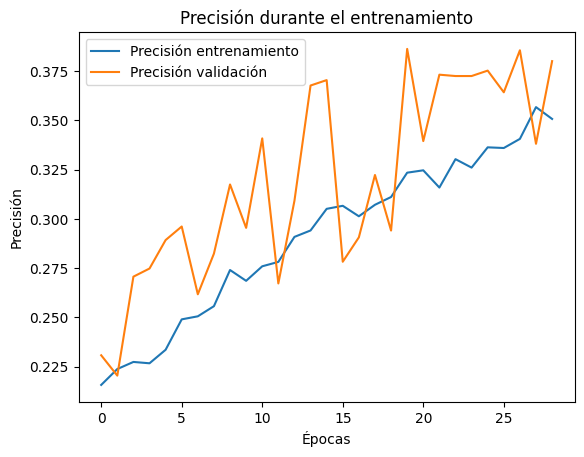

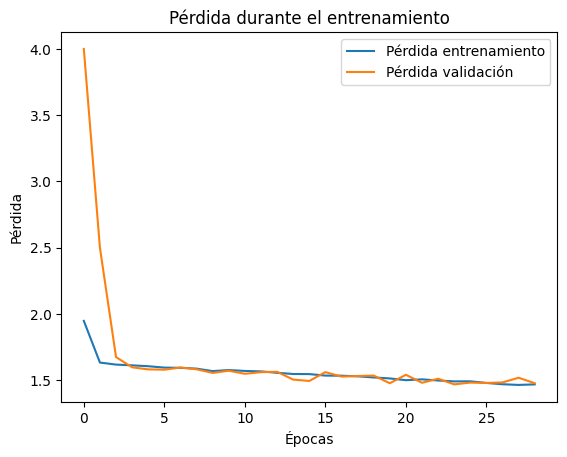

In [81]:
# Visualización de precisión y pérdida
plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Precisión durante el entrenamiento')
plt.show()

plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida durante el entrenamiento')
plt.show()

Resultados

46/46 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.3236 - loss: 1.4917
Precisión en validación: 0.37
Pérdida en validación: 1.47
46/46 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step


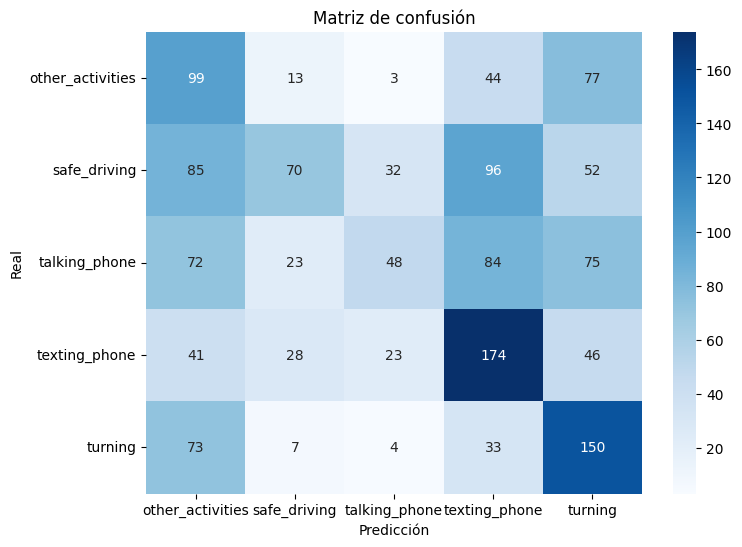

In [82]:
# Evaluación final
val_loss, val_acc = model.evaluate(val_gen)
print(f'Precisión en validación: {val_acc:.2f}')
print(f'Pérdida en validación: {val_loss:.2f}')

# Matriz de confusión visual
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_gen.classes

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


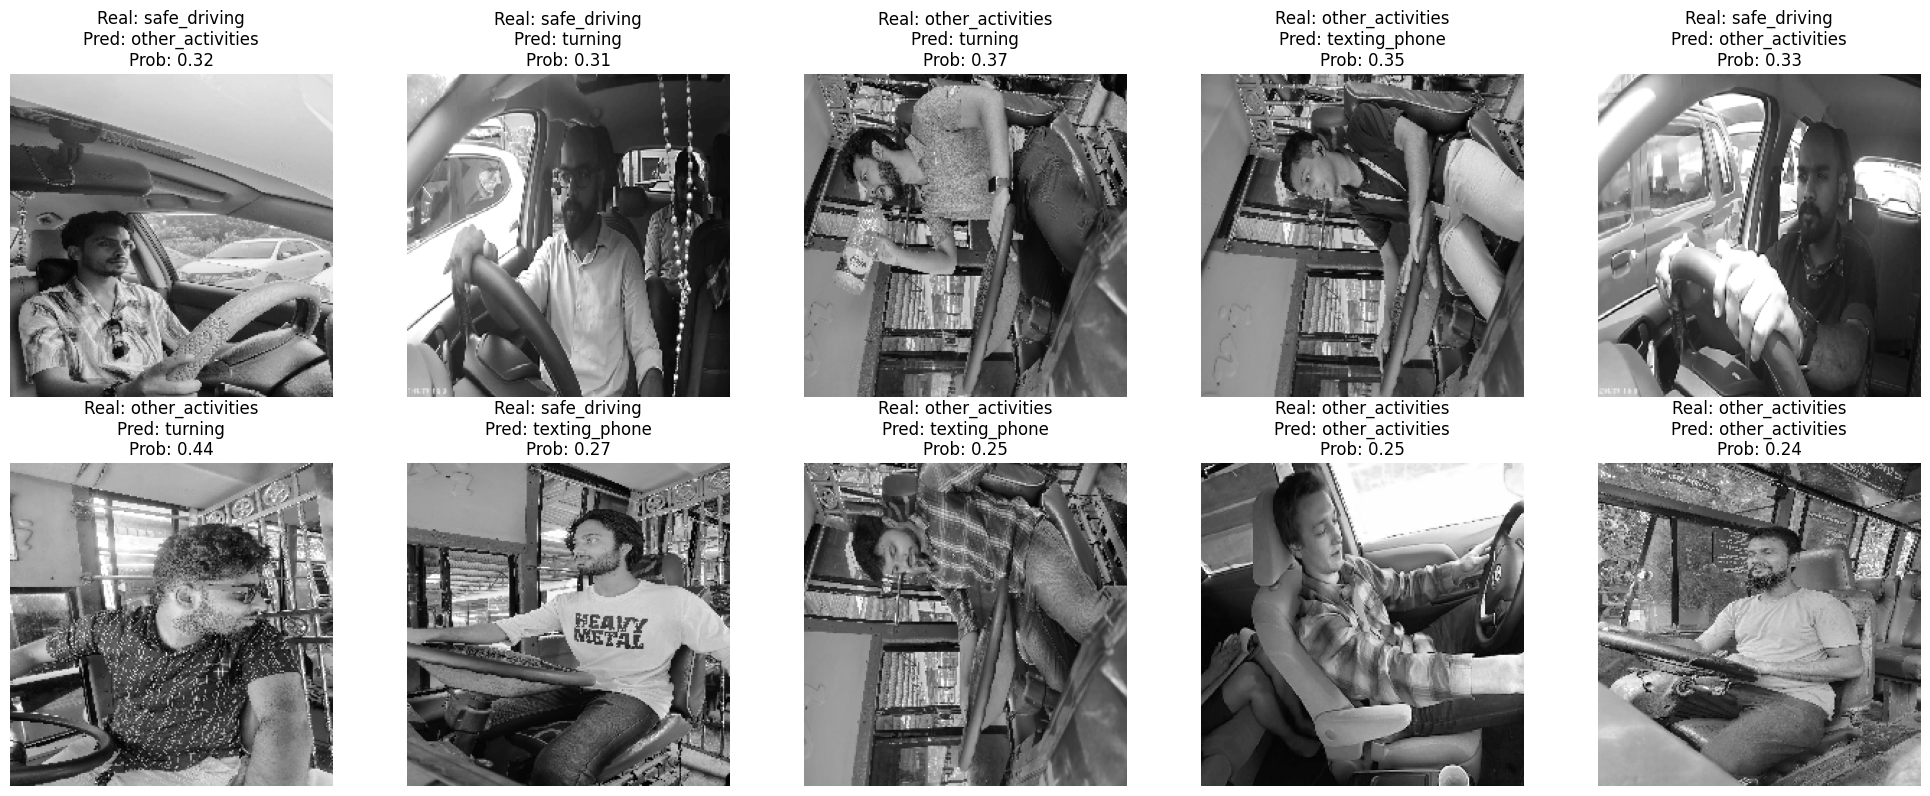

In [83]:
# Visualizar ejemplos con predicción y probabilidad
x_val, y_val = next(val_gen)
for _ in range(5):
    x_temp, y_temp = next(val_gen)
    x_val = np.concatenate([x_val, x_temp], axis=0)
    y_val = np.concatenate([y_val, y_temp], axis=0)

num_ejemplos = 10
indices = random.sample(range(x_val.shape[0]), num_ejemplos)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, idx in enumerate(indices):
    img = x_val[idx:idx+1]
    label = y_val[idx]
    pred = model.predict(img)
    pred_class = np.argmax(pred, axis=1)[0]
    true_class = np.argmax(label)
    prob = np.max(pred)
    ax = axes[i//5, i%5]
    if img.shape[-1] == 1:
        ax.imshow(img[0].squeeze(), cmap='gray')
    else:
        ax.imshow(img[0])
    ax.axis('off')
    ax.set_title(f"Real: {class_labels[true_class]}\nPred: {class_labels[pred_class]}\nProb: {prob:.2f}")

plt.tight_layout()
plt.show()

In [84]:
# Reporte de clasificación
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print("Reporte de clasificación:")
print(report)


Reporte de clasificación:
                  precision    recall  f1-score   support

other_activities       0.27      0.42      0.33       236
    safe_driving       0.50      0.21      0.29       335
   talking_phone       0.44      0.16      0.23       302
   texting_phone       0.40      0.56      0.47       312
         turning       0.38      0.56      0.45       267

        accuracy                           0.37      1452
       macro avg       0.40      0.38      0.35      1452
    weighted avg       0.40      0.37      0.35      1452



## Presenta una mejora muy buena pero sigue siendo inexacta la matriz dice que determina de mejor manerando textea en el celular o turning, y con las imagenes de arriba verificando lo que dice al partecer lo que evita que diferencie de manera clara que conduce de manera correcta y otras actividades es por la forma o posicion de la cabeza no es muy diferentes entre si por ende lo mejor sera probrarlo pero con un entrenamiento muchisimo mas grandes y tardado.

# Prueba con un CNN con todo lo Aprendido y mayor tiempo de entrenamiento

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


In [86]:

# Parámetros
img_size = (256, 256) #camiar dependiendo de la memoria de la maquina
batch_size = 32
ruta_imagenes = "Multi-Class Driver Behavior Image Dataset"

# Data Augmentation MODERADO (no distorsiona mucho)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,         # Menor rotación
    width_shift_range=0.05,    # Menor desplazamiento
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

# Generadores en escala de grises
train_gen = train_datagen.flow_from_directory(
    ruta_imagenes,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True
)
val_gen = val_datagen.flow_from_directory(
    ruta_imagenes,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

Found 7276 images belonging to 5 classes.
Found 7276 images belonging to 5 classes.


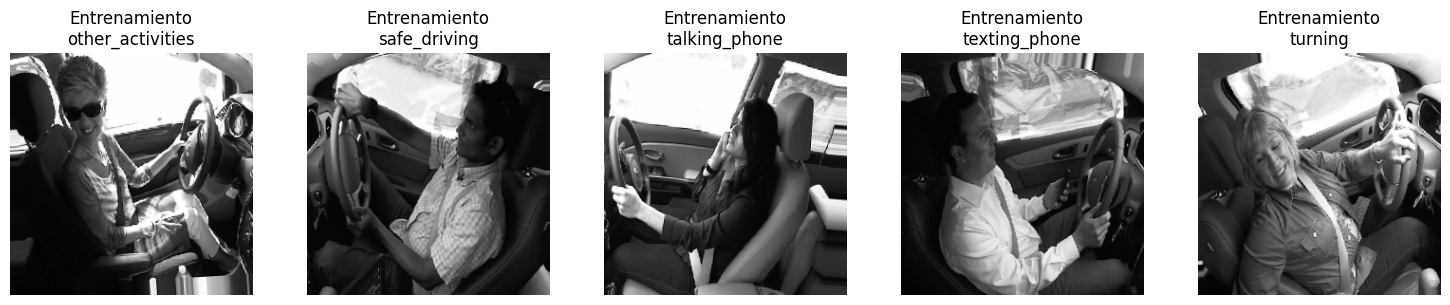

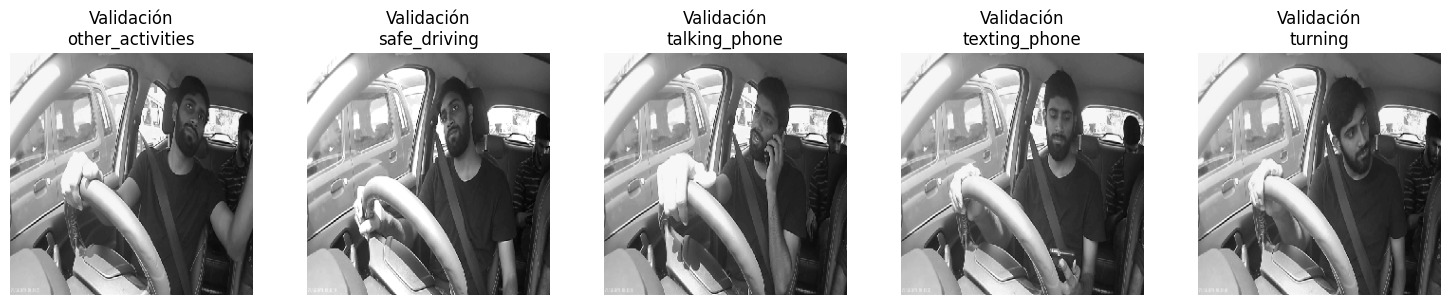

In [87]:
# Visualización de ejemplos de cada clase
class_labels = list(train_gen.class_indices.keys())
num_classes = len(class_labels)

def mostrar_imagenes_por_clase(generator, tipo="Entrenamiento"):
    plt.figure(figsize=(15, 3))
    for i, class_name in enumerate(class_labels):
        encontrado = False
        while not encontrado:
            x_batch, y_batch = next(generator)
            for j in range(x_batch.shape[0]):
                label = np.argmax(y_batch[j])
                if label == i:
                    plt.subplot(1, num_classes, i+1)
                    plt.imshow(x_batch[j].squeeze(), cmap='gray')
                    plt.title(f"{tipo}\n{class_name}")
                    plt.axis('off')
                    encontrado = True
                    break
    plt.tight_layout()
    plt.show()

mostrar_imagenes_por_clase(train_gen, tipo="Entrenamiento")
mostrar_imagenes_por_clase(val_gen, tipo="Validación")

In [88]:
# Calcular class_weight para oversampling virtual
labels = []
for clase in class_labels:
    clase_path = os.path.join(ruta_imagenes, clase)
    if os.path.isdir(clase_path):
        num_imgs = len([f for f in os.listdir(clase_path) if os.path.isfile(os.path.join(clase_path, f))])
        labels += [clase] * num_imgs
y_int = [class_labels.index(lbl) for lbl in labels]
class_weights = compute_class_weight('balanced', classes=np.unique(y_int), y=y_int)
class_weights_dict = dict(enumerate(class_weights))
print("Pesos para oversampling:", class_weights_dict)


Pesos para oversampling: {0: 1.229054054054054, 1: 0.8667063728409767, 2: 0.9617977528089887, 3: 0.932222934016656, 4: 1.0867811799850635}


In [90]:

# Definición de la CNN desde cero para escala de grises
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=img_size + (1,)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

Epoch 1/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 574s 3s/step - accuracy: 0.2087 - loss: 2.7353 - val_accuracy: 0.2195 - val_loss: 1.7568
Epoch 2/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 562s 2s/step - accuracy: 0.2569 - loss: 1.8534 - val_accuracy: 0.3091 - val_loss: 1.6110
Epoch 3/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 562s 2s/step - accuracy: 0.2885 - loss: 1.6539 - val_accuracy: 0.3936 - val_loss: 1.4637
Epoch 4/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 564s 2s/step - accuracy: 0.3063 - loss: 1.5842 - val_accuracy: 0.4094 - val_loss: 1.4480
Epoch 5/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 540s 2s/step - accuracy: 0.3161 - loss: 1.5580 - val_accuracy: 0.4360 - val_loss: 1.4066
Epoch 6/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 513s 2s/step - accuracy: 0.3524 - loss: 1.4936 - val_accuracy: 0.4582 - val_loss: 1.3636
Epoch 7/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 513s 2s/step - accuracy: 0.3641 - loss: 1.4804 - val_accuracy: 0.4667 - val_loss: 1.3323
Epoch 8/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 514s 2s/step - accuracy: 0.3817 - loss: 1.4577 - val_accu

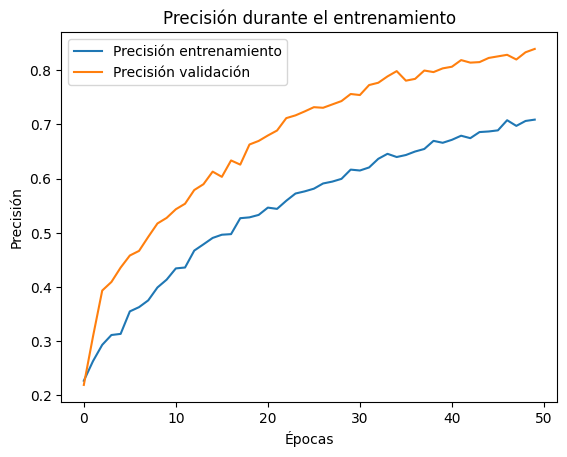

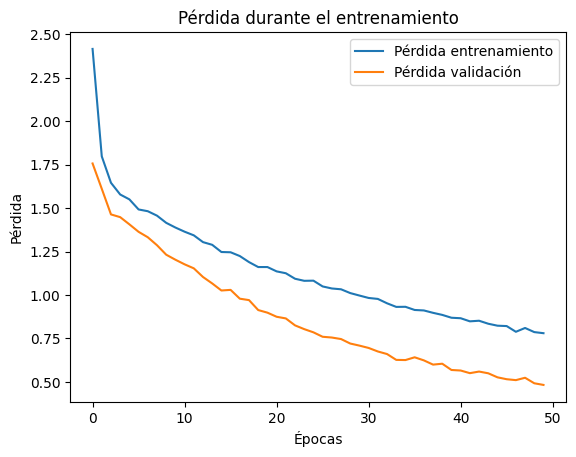

228/228 ━━━━━━━━━━━━━━━━━━━━ 92s 404ms/step - accuracy: 0.7943 - loss: 0.6218
Precisión en validación: 0.84
Pérdida en validación: 0.48


In [91]:
# Visualización de precisión y pérdida
plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Precisión durante el entrenamiento')
plt.show()

plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida durante el entrenamiento')
plt.show()

# Evaluación final
val_loss, val_acc = model.evaluate(val_gen)
print(f'Precisión en validación: {val_acc:.2f}')
print(f'Pérdida en validación: {val_loss:.2f}')

228/228 ━━━━━━━━━━━━━━━━━━━━ 92s 400ms/step


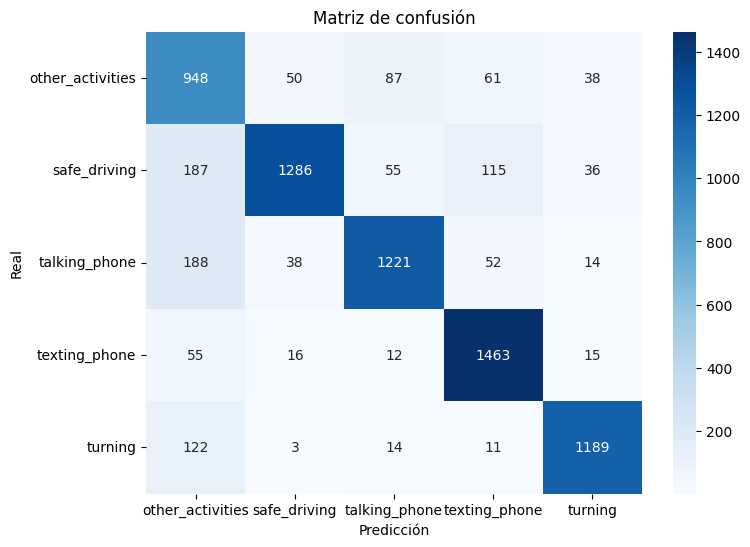

In [92]:
# Matriz de confusión visual
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_gen.classes

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


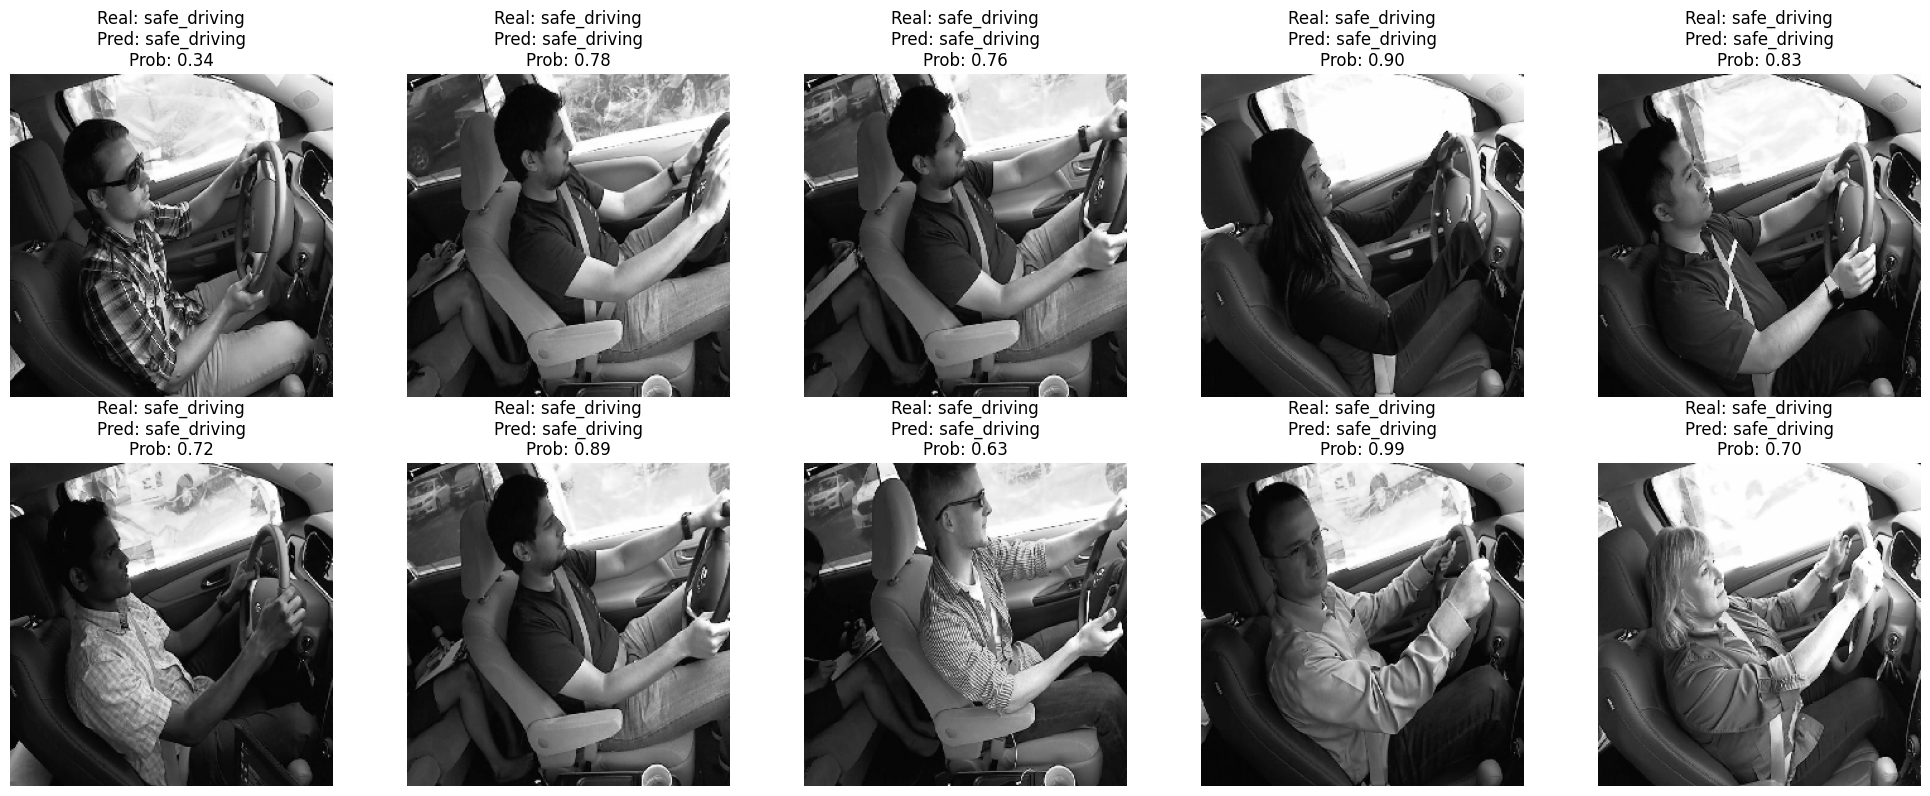

In [112]:
# Visualizar ejemplos con predicción y probabilidad
x_val, y_val = next(val_gen)
for _ in range(5):
    x_temp, y_temp = next(val_gen)
    x_val = np.concatenate([x_val, x_temp], axis=0)
    y_val = np.concatenate([y_val, y_temp], axis=0)

num_ejemplos = 10
indices = random.sample(range(x_val.shape[0]), num_ejemplos)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, idx in enumerate(indices):
    img = x_val[idx:idx+1]
    label = y_val[idx]
    pred = model.predict(img)
    pred_class = np.argmax(pred, axis=1)[0]
    true_class = np.argmax(label)
    prob = np.max(pred)
    ax = axes[i//5, i%5]
    ax.imshow(img[0].squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Real: {class_labels[true_class]}\nPred: {class_labels[pred_class]}\nProb: {prob:.2f}")

plt.tight_layout()
plt.show()

### Clasificacion

In [110]:
# Reporte de clasificación
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print("Reporte de clasificación:")
print(report)

Reporte de clasificación:
                  precision    recall  f1-score   support

other_activities       0.63      0.80      0.71      1184
    safe_driving       0.92      0.77      0.84      1679
   talking_phone       0.88      0.81      0.84      1513
   texting_phone       0.86      0.94      0.90      1561
         turning       0.92      0.89      0.90      1339

        accuracy                           0.84      7276
       macro avg       0.84      0.84      0.84      7276
    weighted avg       0.85      0.84      0.84      7276



## El modelo aprendio de manera correcta despues de un entrenamiento de 50 eposch y 438 min (7 horas y 18 min) obtuvo estos resultados, como se evidencia en la matriz de confusión en el aspecto que mas errores presenta es el tipo de otras distracciones y esto se debe principalmente a que muchas de las poses se los otros tipos de casos son muy parecidas con este ya sea por la posicion de la cabeza o manos pero sobre todo cosas minusculas en el rostro, ya que el data set si revisamos las imagenes son muy parecidas las posiciones y aun para un humano debe ver bien el rostro para diferenciarlo, por lo que lo mejor de este caso es tener una vista de la imagen y ver lo que predice el algoritmo y lo que es enrealidad solo por si acaso ya que el acierto del modelo es del 84 porciento de las veces.

Para mejorar el modelo podriamos agregar mas imagenes al data set no artificiales y aumentar la capacidad de computo para que demore menos tiempo el programa en entrenarse, y ver las diferencias que se pueden dar si dejamos las imagenes en rgb o en escala de grises, ya que los colores no son importantes para determinar el tipo de caso de distraccion pero no tenemos la certesa de que afecte o no en el acierto del modelo( pero si afecta el tiempo de entrenamiento como en el primer intento de modelo)

# Guardar modelo y como llamarlo para que lo usen en pruebas

In [113]:
# Guarda el modelo completo (estructura + pesos + optimizador)
model.save('modelo_cnn_grayscale_balanced.h5')
print("Modelo guardado como modelo_cnn_grayscale_balanced.h5")

Modelo guardado como modelo_cnn_grayscale_balanced.h5


In [114]:
from tensorflow.keras.models import load_model

# Cargar el modelo cuando lo necesites
modelo_cargado = load_model('modelo_cnn_grayscale_balanced.h5')
print("Modelo cargado correctamente")

Modelo cargado correctamente


# Prueba de modelo ( ya tiene aqui el codigo para llamar el modelo solo debe tenerlo descargado)

Clases disponibles: ['other_activities', 'safe_driving', 'talking_phone', 'texting_phone', 'turning']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

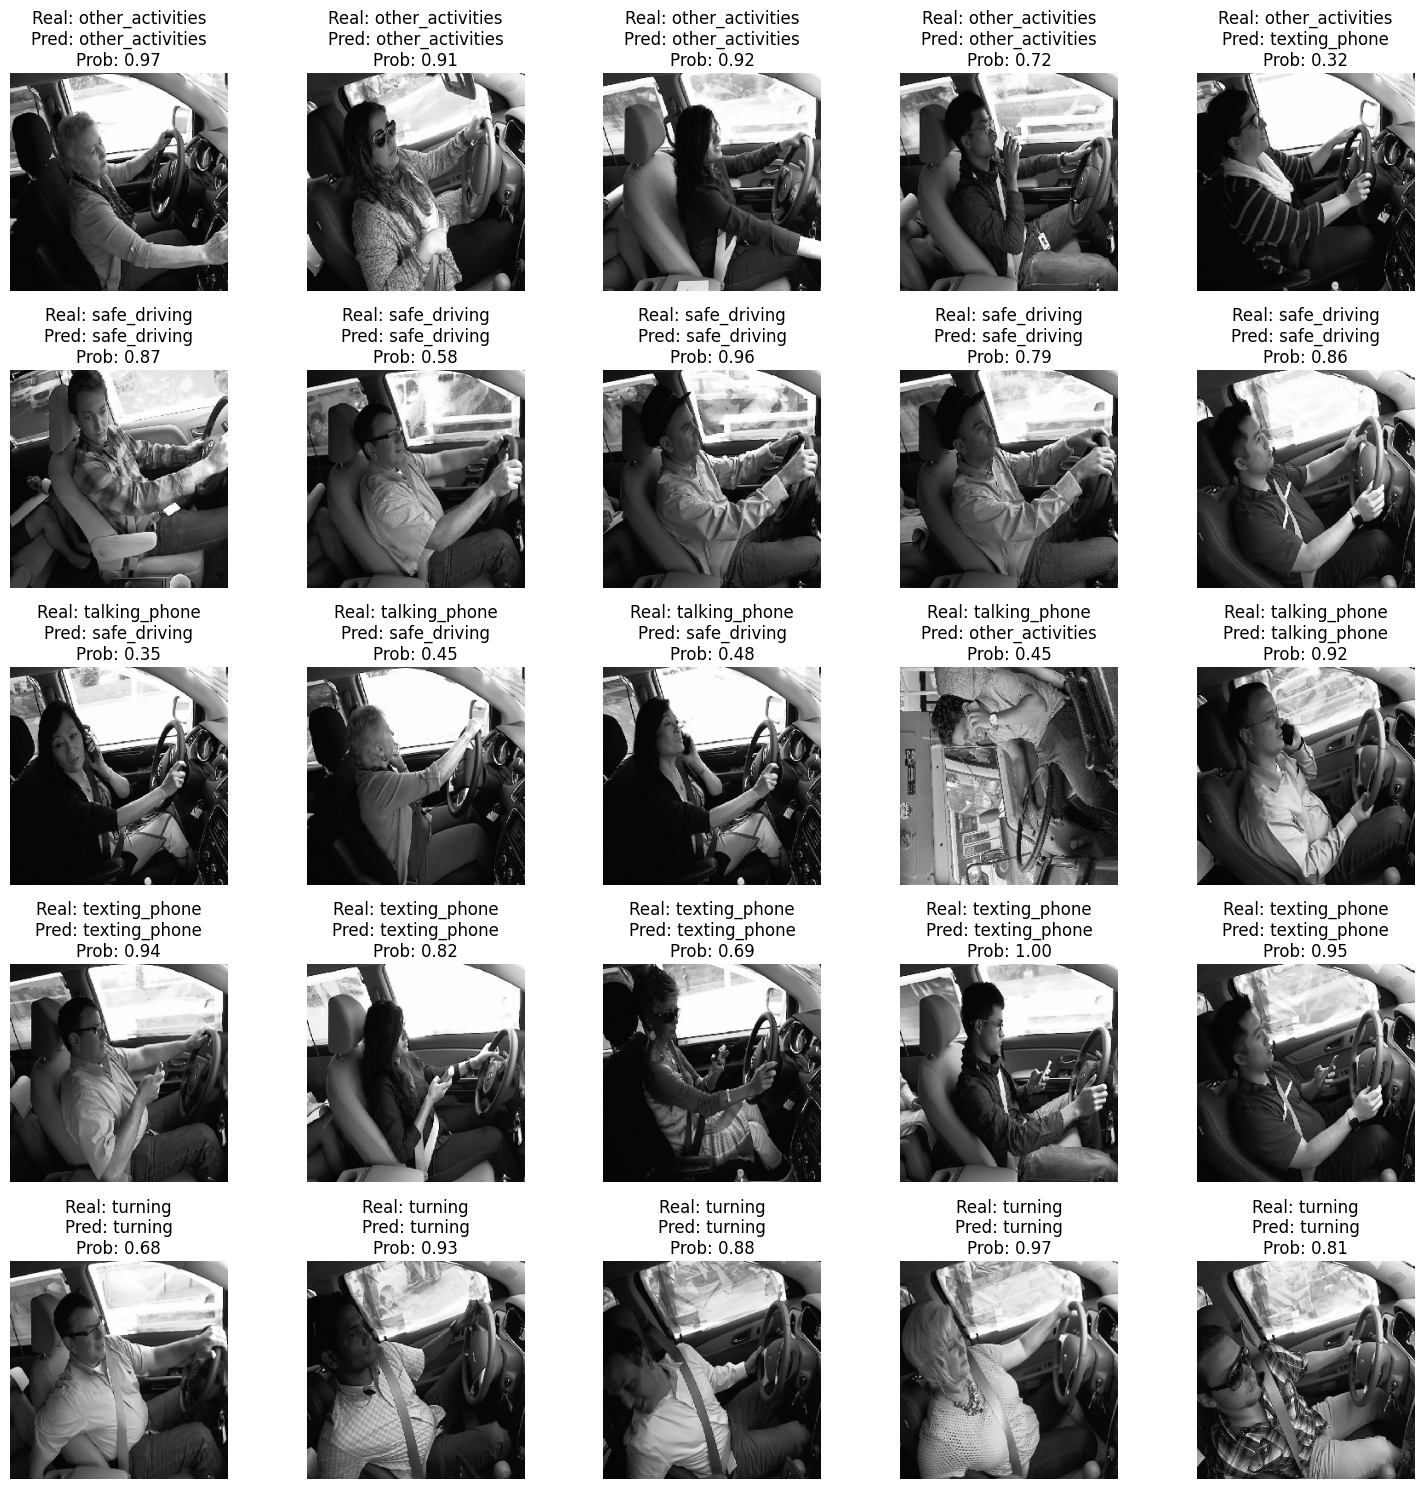

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import random

# Cargar el modelo
modelo = load_model('../models/modelo_cnn_grayscale_balanced.h5')

# Parámetros
img_size = (256, 256)  # Usa el tamaño que usaste para entrenar
ruta_imagenes = "./muestra_aleatoria/"
class_labels = sorted([d for d in os.listdir(ruta_imagenes) if os.path.isdir(os.path.join(ruta_imagenes, d))])
print("Clases disponibles:", class_labels)
# Función para cargar y preprocesar una imagen en escala de grises
def cargar_img_grayscale(path, img_size):
    img = image.load_img(path, color_mode='grayscale', target_size=img_size)
    x = image.img_to_array(img)
    x = x / 255.0
    x = np.expand_dims(x, axis=0)
    return x

# Seleccionar 5 imágenes aleatorias de cada clase y predecir
fig, axes = plt.subplots(len(class_labels), 5, figsize=(15, 3 * len(class_labels)))
for i, clase in enumerate(class_labels):
    clase_path = os.path.join(ruta_imagenes, clase)
    imagenes = [f for f in os.listdir(clase_path) if os.path.isfile(os.path.join(clase_path, f))]
    seleccionadas = random.sample(imagenes, 5)
    for j, img_name in enumerate(seleccionadas):
        img_path = os.path.join(clase_path, img_name)
        x = cargar_img_grayscale(img_path, img_size)
        pred = modelo.predict(x)
        pred_class = np.argmax(pred)
        prob = np.max(pred)
        ax = axes[i, j]
        ax.imshow(x[0].squeeze(), cmap='gray')
        ax.axis('off')
        ax.set_title(f"Real: {clase}\nPred: {class_labels[pred_class]}\nProb: {prob:.2f}")

plt.tight_layout()
plt.show()

In [4]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Clases del modelo
class_labels = ['other_activities', 'safe_driving', 'talking_phone', 'texting_phone', 'turning']

# Función para predecir una sola imagen
def predecir_imagen(modelo, img_path, img_size=(256, 256)):
    """
    Predice la clase de una imagen utilizando el modelo entrenado.

    Args:
        modelo: Modelo cargado de Keras.
        img_path: Ruta de la imagen a predecir.
        img_size: Tamaño de la imagen (debe coincidir con el tamaño usado en el entrenamiento).

    Returns:
        dict: Clase predicha y probabilidad asociada.
    """
    # Cargar y preprocesar la imagen
    img = image.load_img(img_path, color_mode='grayscale', target_size=img_size)
    x = image.img_to_array(img)
    x = x / 255.0
    x = np.expand_dims(x, axis=0)

    # Realizar la predicción
    pred = modelo.predict(x)
    pred_class = np.argmax(pred)
    prob = np.max(pred)

    # Resultado
    return {
        "clase_predicha": class_labels[pred_class],
        "probabilidad": prob
    }

# Ejemplo de uso
modelo = load_model('../models/modelo_cnn_grayscale_balanced.h5')  # Cargar el modelo previamente guardado
resultado = predecir_imagen(modelo, './muestra_aleatoria/talking_phone/img_44535.jpg')
print(f"Clase predicha: {resultado['clase_predicha']}, Probabilidad: {resultado['probabilidad']:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Clase predicha: safe_driving, Probabilidad: 0.48
